In [1]:
import sampling
import data_loader
import os 
import re
from torch_geometric.utils.convert import from_networkx
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

import random
import pickle
import torch
from models import graph_classifier, gnn_models
from torch_geometric.loader import DataLoader
import pandas as pd
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from evaluation import evaluation

### Load the input data

In [2]:
#f_loader = data_loader.RetinaLoader("/home/laurin/Documents/retina/graphs", "/home/laurin/Documents/retina/labels.xlsx")

In [3]:
#data_list = f_loader.get_dual_data_list(add_structural = True, two_cls = False, force = True) 
#with open('data_list_OCTA.pkl', 'wb') as f:
#    pickle.dump(data_list, f)

with open('data_list_OCTA.pkl', 'rb') as f:
    data_list = pickle.load(f)


data_list_2cls = [] # put CNV and AMD to normal class
data_list_2cls_filt = [] # creates a data_list where 

for data in data_list:
    data.clone
    if data.y > 1:
        data_c = data.clone()
        data_c.y = 0
        data_list_2cls.append(data_c)
    else:
        data_list_2cls_filt.append(data)
        data_list_2cls.append(data)

### Split the data into a train and test set

In [4]:
np.random.seed(0)

train_mask = np.random.choice(np.arange(0, len(data_list)), size= int(len(data_list)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(data_list)), train_mask)

train_list_bin = []
test_list_bin = []

for i, data in enumerate(data_list):
    if i in train_mask:
        train_list_bin.append(data)
    else:
        test_list_bin.append(data)

In [5]:
train_labels = [lab["y"] for lab in train_list_bin]
print(np.unique(train_labels, return_counts= True))
np.unique(train_labels, return_counts= True)[1]
test_labels = [lab["y"] for lab in test_list_bin]
print(np.unique(test_labels, return_counts= True))

(array([0, 1, 2, 3]), array([126,  25,   4,   5]))
(array([0, 1, 2, 3]), array([34,  4,  1,  1]))


# 4 Class

### Split the data with 5-fold CV

In [6]:
y = [data.y for data in data_list]

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5, random_state = 0, shuffle= True)
skf.get_n_splits(np.arange(0, len(data_list)), y)

splits = []
for train_idx, test_idx in skf.split(np.arange(0, len(data_list)), y):
    train_list = []
    test_list = []
    for i, data in enumerate(data_list):
        if i in train_idx:
            train_list.append(data)
        else:
            test_list.append(data)
    splits.append((train_list,test_list))

In [7]:
# selection of the features to use
num_features = data_list[0].x.shape[1]
num_classes = 4
epochs = 100

# try different aggregation modes:
# other aggragtion schemas not supported for batches

fig, ax = plt.subplots(1,5, figsize=(20,4))


for i, split in enumerate(splits):
    # create the model
    model = gnn_models.GCN_GC(in_channels= num_features, hidden_channels = 64, out_channels= num_classes, num_layers= 3, dropout = 0.2, aggregation_mode= global_mean_pool)

    # create brach data loaders for training and test set
    train_loader = DataLoader(split[0], batch_size = 32, shuffle=True)
    test_loader = DataLoader(split[1], batch_size = 32, shuffle=False)

    # weigthings for imbalanced classes 
    train_labels = [lab["y"] for lab in split[0]]
    weights = 1/np.unique(train_labels, return_counts= True)[1]
    balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).float())

    classifier = graph_classifier.graphClassifierBatch(model, train_loader, test_loader, balanced_loss)

    print("Split " + str(i+1))
    for epoch in range(1, epochs+1):
        classifier.train()
        train_acc = classifier.test(train_loader)
        test_acc = classifier.test(test_loader)
        outList, yList = classifier.predict(test_loader)
        y_p = np.array([item.argmax().detach().numpy() for sublist in outList for item in sublist])
        y_t = np.array([item.detach().numpy() for sublist in yList for item in sublist])
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')
    evaluation.plot_confusion_matrix(y_t, y_p, ["NORMAL", "DR", "CNV", "AMD"], ax[i])



Split 1
Epoch: 001, Train Acc: 0.0250, Test Acc: 0.0250, Test Bal Acc: 0.2500
Epoch: 002, Train Acc: 0.8938, Test Acc: 0.8750, Test Bal Acc: 0.3750
Epoch: 003, Train Acc: 0.8125, Test Acc: 0.8500, Test Bal Acc: 0.3333
Epoch: 004, Train Acc: 0.1313, Test Acc: 0.1000, Test Bal Acc: 0.1667
Epoch: 005, Train Acc: 0.1250, Test Acc: 0.1250, Test Bal Acc: 0.4167
Epoch: 006, Train Acc: 0.8875, Test Acc: 0.8750, Test Bal Acc: 0.3750
Epoch: 007, Train Acc: 0.7625, Test Acc: 0.8500, Test Bal Acc: 0.4688
Epoch: 008, Train Acc: 0.8938, Test Acc: 0.9000, Test Bal Acc: 0.4167
Epoch: 009, Train Acc: 0.8938, Test Acc: 0.9000, Test Bal Acc: 0.4167
Epoch: 010, Train Acc: 0.5312, Test Acc: 0.5500, Test Bal Acc: 0.5833
Epoch: 011, Train Acc: 0.8812, Test Acc: 0.8750, Test Bal Acc: 0.3750
Epoch: 012, Train Acc: 0.8688, Test Acc: 0.9250, Test Bal Acc: 0.4583


# 2 Class

In [ ]:
y = [data.y for data in data_list_2cls]

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5, random_state = 0, shuffle= True)
skf.get_n_splits(np.arange(0, len(data_list_2cls)), y)

splits = []
for train_idx, test_idx in skf.split(np.arange(0, len(data_list_2cls)), y):
    train_list = []
    test_list = []
    for i, data in enumerate(data_list_2cls):
        if i in train_idx:
            train_list.append(data)
        else:
            test_list.append(data)
    splits.append((train_list,test_list))

Split 1
Epoch: 001, Train Acc: 0.8500, Test Acc: 0.8750, Test Bal Acc: 0.5000
Epoch: 002, Train Acc: 0.1500, Test Acc: 0.1250, Test Bal Acc: 0.5000
Split 2
Epoch: 001, Train Acc: 0.1437, Test Acc: 0.1500, Test Bal Acc: 0.5000
Epoch: 002, Train Acc: 0.9250, Test Acc: 0.9500, Test Bal Acc: 0.8333
Split 3
Epoch: 001, Train Acc: 0.1437, Test Acc: 0.1500, Test Bal Acc: 0.5000
Epoch: 002, Train Acc: 0.8562, Test Acc: 0.8500, Test Bal Acc: 0.5000
Split 4
Epoch: 001, Train Acc: 0.8562, Test Acc: 0.8500, Test Bal Acc: 0.5000
Epoch: 002, Train Acc: 0.1437, Test Acc: 0.1500, Test Bal Acc: 0.5000
Split 5
Epoch: 001, Train Acc: 0.9187, Test Acc: 0.9000, Test Bal Acc: 0.6667
Epoch: 002, Train Acc: 0.9375, Test Acc: 0.9000, Test Bal Acc: 0.6667


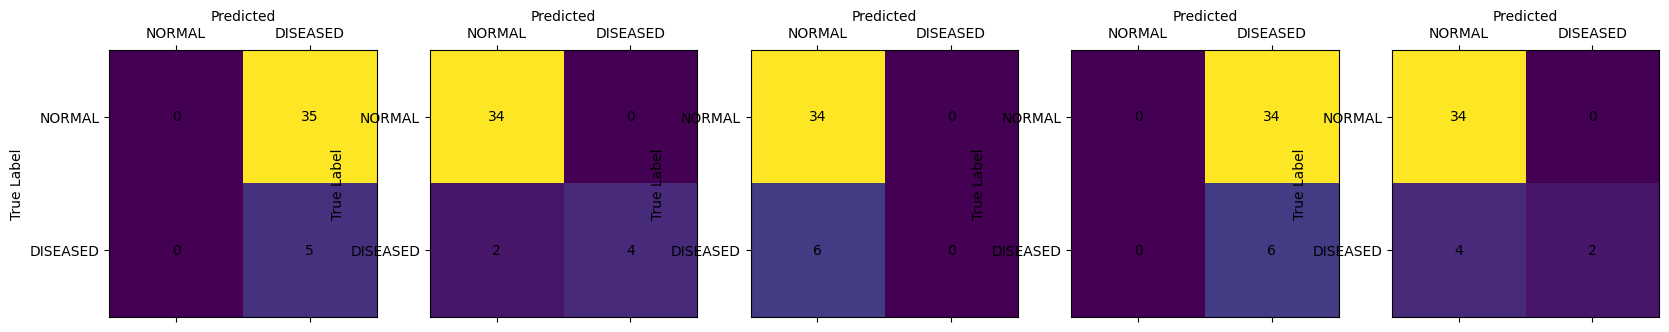

In [ ]:
# selection of the features to use
num_features = data_list_2cls[0].x.shape[1]
num_classes = 2
epochs = 100

# try different aggregation modes:
# other aggragtion schemas not supported for batches

fig, ax = plt.subplots(1,5, figsize=(20,4))


for i, split in enumerate(splits):
    # create the model
    model = gnn_models.GCN_GC(in_channels= num_features, hidden_channels = 64, out_channels= num_classes, num_layers= 3, dropout = 0.2, aggregation_mode= global_mean_pool)

    # create brach data loaders for training and test set
    train_loader = DataLoader(split[0], batch_size = 32, shuffle=True)
    test_loader = DataLoader(split[1], batch_size = 32, shuffle=False)

    # weigthings for imbalanced classes 
    train_labels = [lab["y"] for lab in split[0]]
    weights = 1/np.unique(train_labels, return_counts= True)[1]
    balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).float())

    classifier = graph_classifier.graphClassifierBatch(model, train_loader, test_loader, balanced_loss)
    

    print("Split " + str(i+1))
    for epoch in range(1, epochs+1):
        classifier.train()
        train_acc = classifier.test(train_loader)
        test_acc = classifier.test(test_loader)
        outList, yList = classifier.predict(test_loader)
        y_p = np.array([item.argmax().detach().numpy() for sublist in outList for item in sublist])
        y_t = np.array([item.detach().numpy() for sublist in yList for item in sublist])
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')
    evaluation.plot_confusion_matrix(y_t, y_p, ["NORMAL", "DISEASED"], ax[i])



# 2 Class fitlered

In [ ]:
y = [data.y for data in data_list_2cls]

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5, random_state = 0, shuffle= True)
skf.get_n_splits(np.arange(0, len(data_list_2cls)), y)

splits = []
for train_idx, test_idx in skf.split(np.arange(0, len(data_list_2cls)), y):
    train_list = []
    test_list = []
    for i, data in enumerate(data_list_2cls):
        if i in train_idx:
            train_list.append(data)
        else:
            test_list.append(data)
    splits.append((train_list,test_list))

In [ ]:
# selection of the features to use
num_features = data_list_2cls_filt[0].x.shape[1]
num_classes = 2
epochs = 100

# try different aggregation modes:
# other aggragtion schemas not supported for batches

fig, ax = plt.subplots(1,5, figsize=(20,4))


for i, split in enumerate(splits):
    # create the model
    model = gnn_models.GCN_GC(in_channels= num_features, hidden_channels = 64, out_channels= num_classes, num_layers= 3, dropout = 0.2, aggregation_mode= global_mean_pool)

    # create brach data loaders for training and test set
    train_loader = DataLoader(split[0], batch_size = 32, shuffle=True)
    test_loader = DataLoader(split[1], batch_size = 32, shuffle=False)

    # weigthings for imbalanced classes 
    train_labels = [lab["y"] for lab in split[0]]
    weights = 1/np.unique(train_labels, return_counts= True)[1]
    balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).float())

    classifier = graph_classifier.graphClassifierBatch(model, train_loader, test_loader, balanced_loss)

    print("Split " + str(i+1))
    for epoch in range(1, epochs+1):
        classifier.train()
        train_acc = classifier.test(train_loader)
        test_acc = classifier.test(test_loader)
        outList, yList = classifier.predict(test_loader)
        y_p = np.array([item.argmax().detach().numpy() for sublist in outList for item in sublist])
        y_t = np.array([item.detach().numpy() for sublist in yList for item in sublist])
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')
    evaluation.plot_confusion_matrix(y_t, y_p, ["NORMAL", "DISEASED"], ax[i])



In [ ]:
## selection of the features to use
#num_features = data_list[0].x.shape[1]
#num_classes = 4
#
#
## try different aggregation modes:
## other aggragtion schemas not supported for batches
#from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
#
#
## create the model
#model = gnn_models.GCN_GC(in_channels= num_features, hidden_channels = 64, out_channels= num_classes, num_layers= 3, dropout = 0.2, aggregation_mode= global_mean_pool)
#
## create brach data loaders for training and test set
#train_loader = DataLoader(train_list_bin, batch_size = 64, shuffle=True)
#test_loader = DataLoader(test_list_bin, batch_size = 64, shuffle=False)
#
## weigthings for imbalanced classes 
#weights = 1/np.unique(train_labels, return_counts= True)[1]
#balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).float())
#
#classifier = graph_classifier.graphClassifierBatch(model, train_loader, test_loader, balanced_loss)
#epochs = 10
#
#for epoch in range(1, epochs+1):
#    classifier.train()
#    train_acc = classifier.test(train_loader)
#    test_acc = classifier.test(test_loader)
#    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')



Epoch: 001, Train Acc: 0.7875, Test Acc: 0.8500
Epoch: 002, Train Acc: 0.7875, Test Acc: 0.8500
Epoch: 003, Train Acc: 0.1062, Test Acc: 0.1250
Epoch: 004, Train Acc: 0.0312, Test Acc: 0.0250
Epoch: 005, Train Acc: 0.1562, Test Acc: 0.1000
Epoch: 006, Train Acc: 0.8812, Test Acc: 0.9500
Epoch: 007, Train Acc: 0.8750, Test Acc: 0.9500
Epoch: 008, Train Acc: 0.1562, Test Acc: 0.1000
Epoch: 009, Train Acc: 0.1562, Test Acc: 0.1000
Epoch: 010, Train Acc: 0.8438, Test Acc: 0.9500
